Connect to Google Drive


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
cd drive/MyDrive/instadeep/InstaDeep/

/content/drive/MyDrive/instadeep/InstaDeep


Packages import

In [3]:
from data import get_dataset
from model import features,classifier,metrics
import tqdm

GPU

In [4]:
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


Data processing

In [5]:
path="random_split/"

test,val,train =get_dataset.get_df(path)

#Due to limitation of computing capacities, we will only consider the 1000 most important classes
classes=features.get_classes_top1000(train)
#apply those changes to train, test, val
test=features.reduce_dataset_1000topclasses(test,classes)
train=features.reduce_dataset_1000topclasses(train,classes)
val=features.reduce_dataset_1000topclasses(val,classes)

#Process inputs 
train_processed=features.process_dataset(train, classes)
test_processed=features.process_dataset(test, classes)
val_processed=features.process_dataset(val, classes)
print(train_processed.shape)
print(test_processed.shape)
print(val_processed.shape)
#Process labels
y_train=features.process_labels(train,classes)
y_test=features.process_labels(test,classes)
y_val=features.process_labels(val,classes)
print(y_train.shape)
print(y_test.shape)
print(y_val.shape)

(439493, 100)
(54378, 100)
(54378, 100)
(439493, 1000)
(54378, 1000)
(54378, 1000)


Simple model : using LSTM

In [6]:
model=classifier.build_model()
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 100, 100)          2100      
_________________________________________________________________
bidirectional (Bidirectional (None, 128)               84480     
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense (Dense)                (None, 1000)              129000    
Total params: 215,580
Trainable params: 215,580
Non-trainable params: 0
_________________________________________________________________
None


In [7]:
history=classifier.train_model(model,train_processed,y_train,val_processed,y_val,epochs=50)


Epoch 1/50
1717/1717 [==============================] - 42s 23ms/step - loss: 7.0284 - accuracy: 0.0356 - val_loss: 3.8091 - val_accuracy: 0.2963
Epoch 2/50
1717/1717 [==============================] - 38s 22ms/step - loss: 3.4350 - accuracy: 0.3581 - val_loss: 2.0863 - val_accuracy: 0.6539
Epoch 3/50
1717/1717 [==============================] - 38s 22ms/step - loss: 2.1159 - accuracy: 0.6228 - val_loss: 1.4363 - val_accuracy: 0.7772
Epoch 4/50
1717/1717 [==============================] - 38s 22ms/step - loss: 1.5625 - accuracy: 0.7285 - val_loss: 1.0852 - val_accuracy: 0.8430
Epoch 5/50
1717/1717 [==============================] - 38s 22ms/step - loss: 1.2767 - accuracy: 0.7803 - val_loss: 0.9014 - val_accuracy: 0.8721
Epoch 6/50
1717/1717 [==============================] - 38s 22ms/step - loss: 1.1140 - accuracy: 0.8099 - val_loss: 0.7799 - val_accuracy: 0.8943
Epoch 7/50
1717/1717 [==============================] - 38s 22ms/step - loss: 0.9940 - accuracy: 0.8325 - val_loss: 0.6848 -

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.6/dist-package

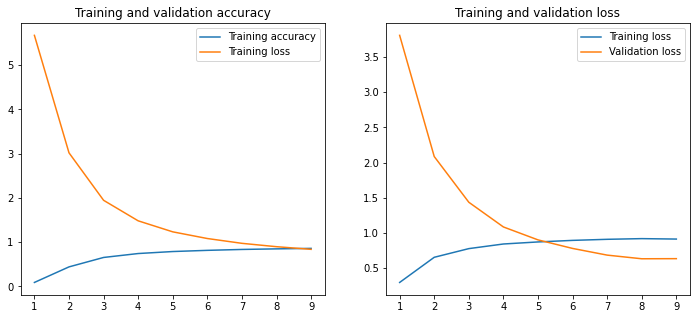

In [8]:
classifier.plot_accuracy_train_val(history)

ProtCNN

In [6]:
#additional preprocessing 
train_2=features.additional_process(train_processed)
val_2=features.additional_process(val_processed)
test_2=features.additional_process(test_processed)


In [7]:
model2=classifier.protccn_model(input_shape=train_2.shape)
print(model2.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (439493, 100, 128)        2816      
_________________________________________________________________
sequential_1 (Sequential)    (439493, 100, 128)        66816     
_________________________________________________________________
sequential_2 (Sequential)    (439493, 100, 128)        66816     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (439493, 33, 128)         0         
_________________________________________________________________
dropout (Dropout)            (439493, 33, 128)         0         
_________________________________________________________________
flatten (Flatten)            (439493, 4224)            0         
_________________________________________________________________
dense (Dense)                (439493, 1000)            4

In [8]:
history2=classifier.train_model(model2,train_2,y_train,val_2,y_val,epochs=50,model_name="protCNN")

Epoch 1/50
1717/1717 [==============================] - 60s 29ms/step - loss: 1.7024 - accuracy: 0.8206 - val_loss: 0.4313 - val_accuracy: 0.9836
Epoch 2/50
1717/1717 [==============================] - 51s 29ms/step - loss: 0.3898 - accuracy: 0.9837 - val_loss: 0.4212 - val_accuracy: 0.9836
Epoch 3/50
1717/1717 [==============================] - 50s 29ms/step - loss: 0.4034 - accuracy: 0.9833 - val_loss: 0.4408 - val_accuracy: 0.9847
Epoch 4/50
1717/1717 [==============================] - 50s 29ms/step - loss: 0.4024 - accuracy: 0.9850 - val_loss: 0.4240 - val_accuracy: 0.9868
Epoch 5/50
1717/1717 [==============================] - 50s 29ms/step - loss: 0.3956 - accuracy: 0.9855 - val_loss: 0.4125 - val_accuracy: 0.9865
Epoch 6/50
1717/1717 [==============================] - 50s 29ms/step - loss: 0.3855 - accuracy: 0.9861 - val_loss: 0.4165 - val_accuracy: 0.9851
Epoch 7/50
1717/1717 [==============================] - 50s 29ms/step - loss: 0.3736 - accuracy: 0.9870 - val_loss: 0.4132 -

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.6/dist-package

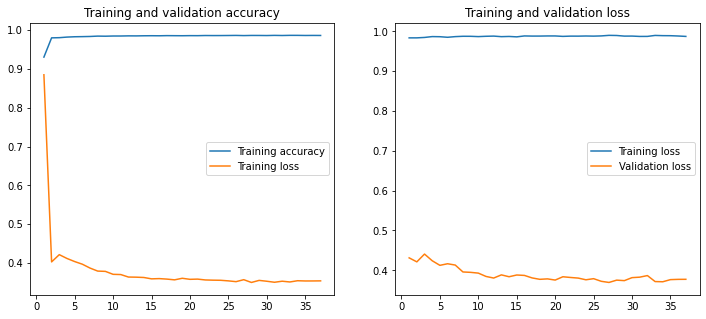

In [10]:
classifier.plot_accuracy_train_val(history2)

In [17]:
y_test

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [18]:
result=model2.evaluate(test_2,y_test)

1700/1700 [==============================] - 6s 4ms/step - loss: 0.3800 - accuracy: 0.9868
